In [1]:
#### Checking against Jerry's stuff
import sys

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import esmpy as E


In [2]:
target_file = '/glade/campaign/cesm/development/espwg/SMYLE-ERA5-L83/inputdata/cesm2_init/b.e21.SMYLE_ERA5_L83_IC.f09_g17.1997-11.01/1997-11-01/b.e21.SMYLE_ERA5_L83_IC.f09_g17.1997-11.01.cam.i.1997-11-01-00000.nc'
#target_file = '/glade/derecho/scratch/juliob/era5-debugging/out-of-the-box//fv1x1/L83/ERA5_x_fv1x1_L83_rgC1_WO.1997-11-01-00000.nc'

#new_file = '/glade/derecho/scratch/juliob/era5-debugging/out-of-the-box//fv1x1/L83/ERA5_x_fv1x1_L83_rgC1_WO.1997-11-01-00000.nc'
#new_file = '/glade/derecho/scratch/juliob/era5-debugging/ps_cam_change//fv1x1/L83/ERA5_x_fv1x1_L83_rgC1_WO.1997-11-01-00000.nc'
#new_file = '/glade/derecho/scratch/juliob/era5-debugging/linear_T_vinterp//fv1x1/L83/ERA5_x_fv1x1_L83_rgC1_WO.1997-11-01-00000.nc'
new_file = '/glade/derecho/scratch/juliob/era5-debugging/back-to-square-1//fv1x1/L83/ERA5_x_fv1x1_L83_rgC1_WO.1997-11-01-00000.nc'
#new_file = '/glade/derecho/scratch/juliob/era5-debugging/serial-vinterp//fv1x1/L83/ERA5_x_fv1x1_L83_rgC1_WO.1997-11-01-00000.nc'
X0 = xr.open_dataset(target_file ,  decode_times=False )

X1 = xr.open_dataset(new_file)


In [3]:

te0=X0.T.values
te1=X1.T.values

ps0=X0.PS.values
ps1=X1.PS.values



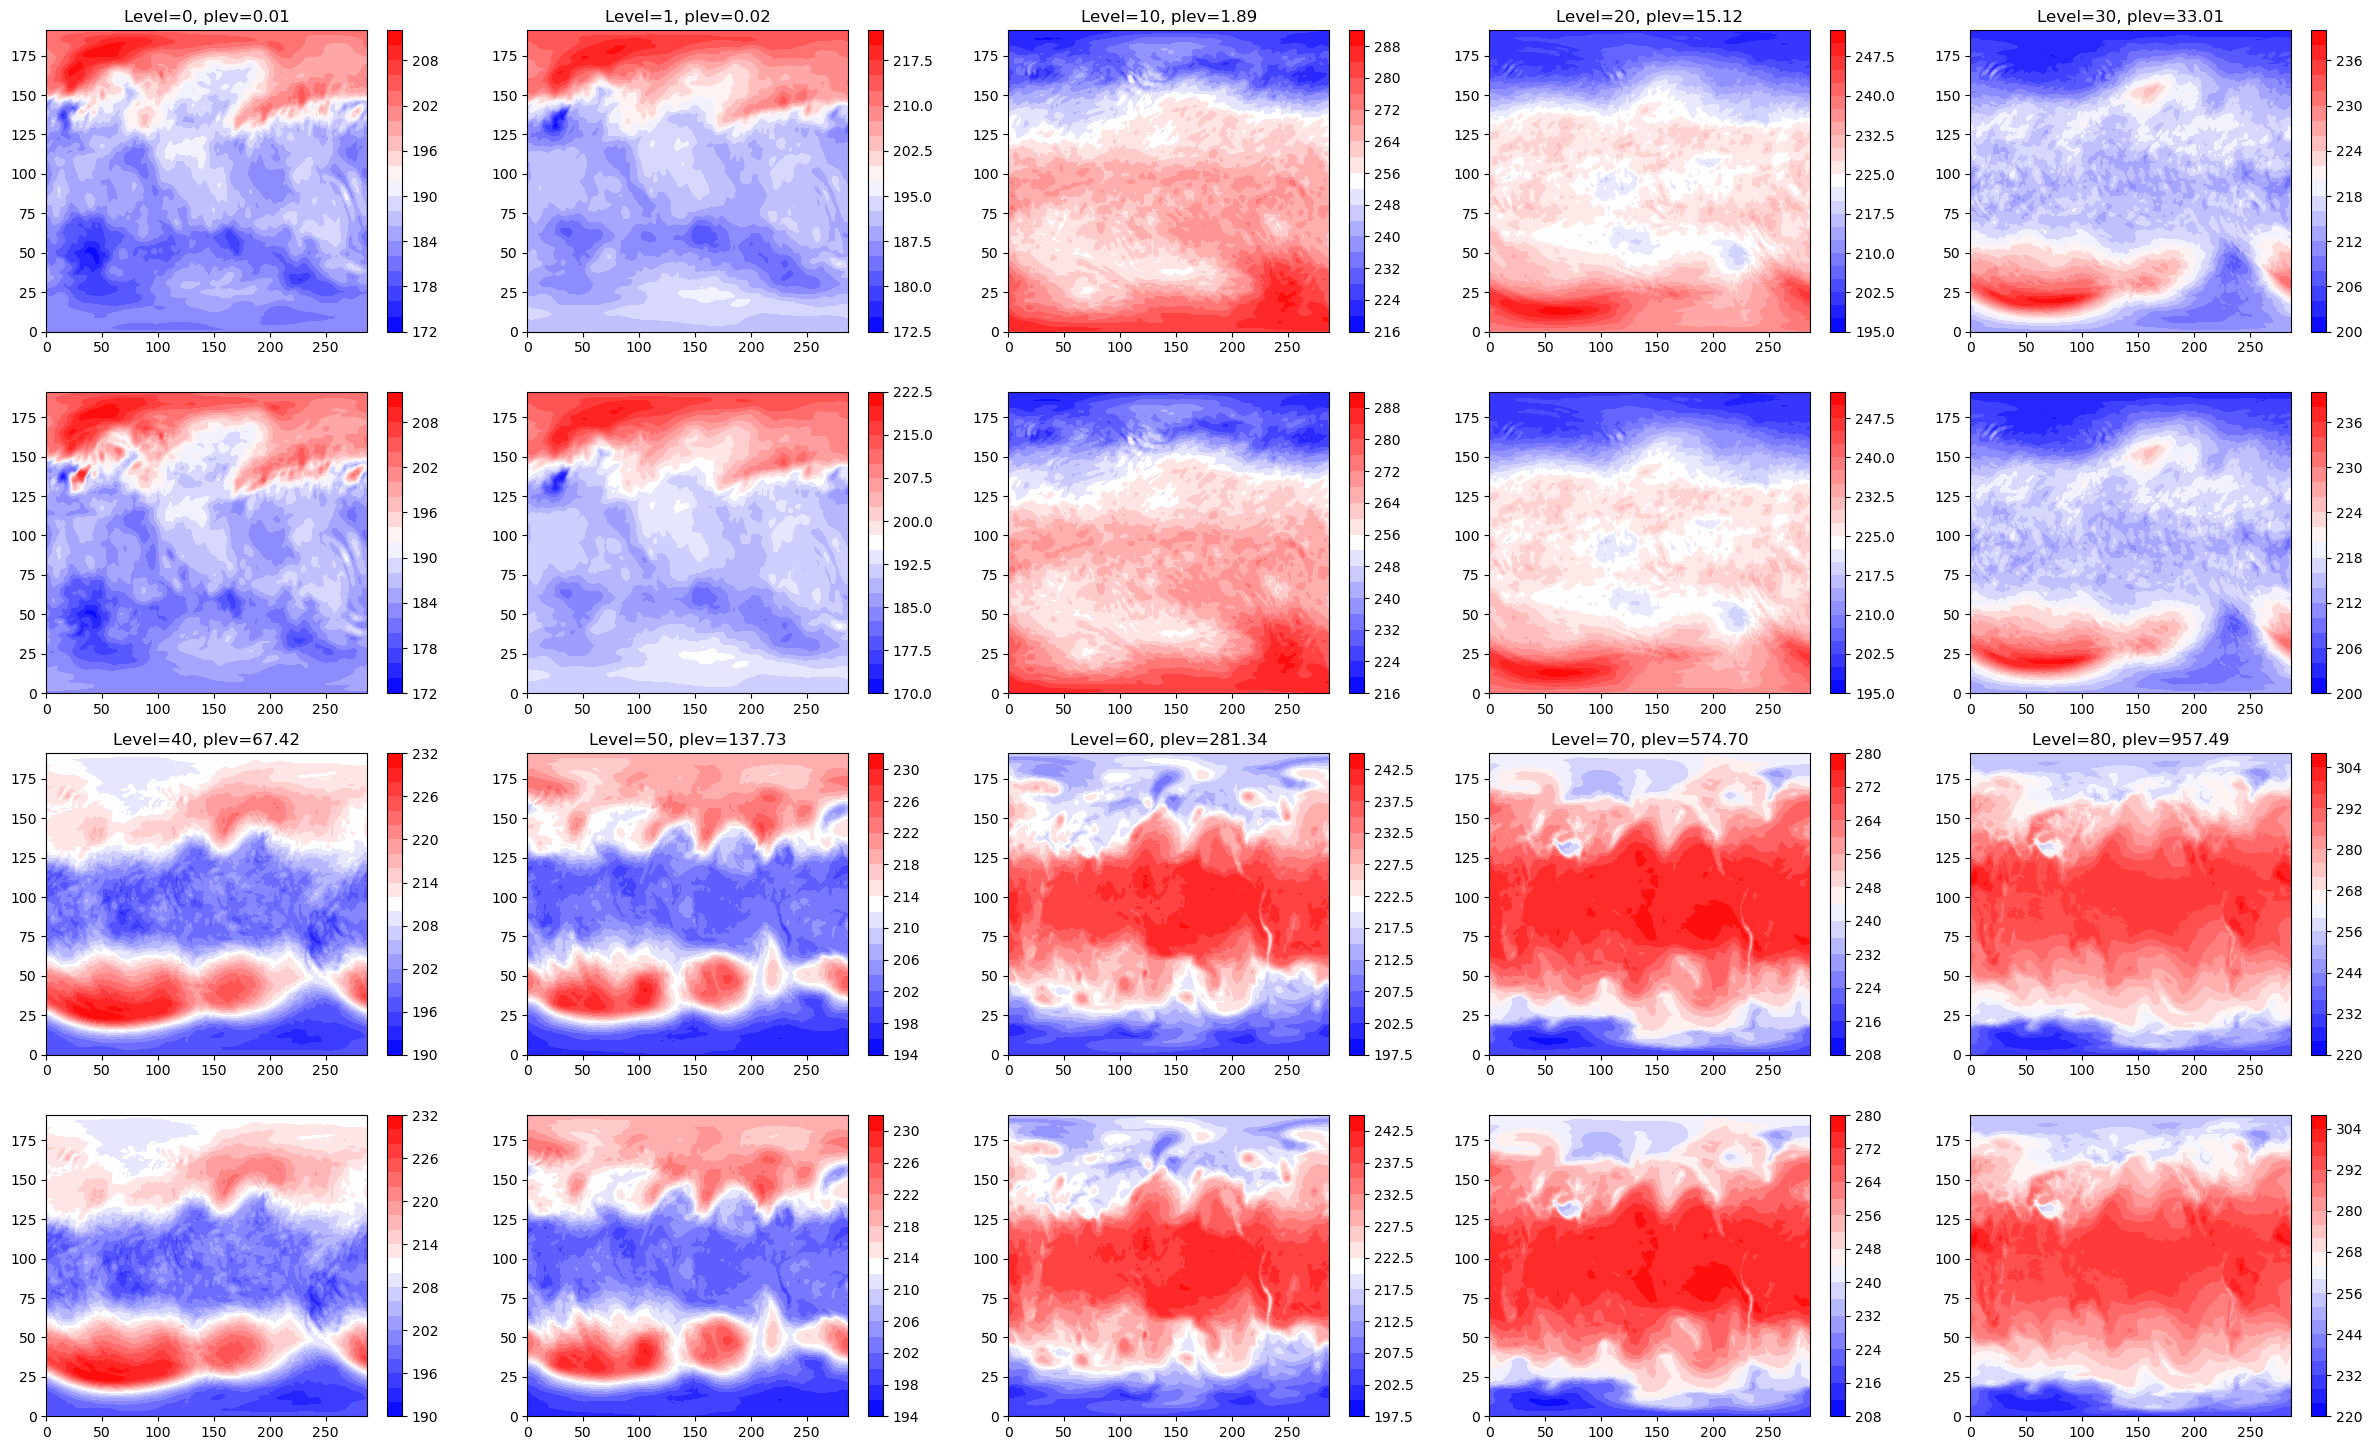

In [4]:
z=0
levs=21 #np.linspace( -1,1,num=21) 

fig, ax = plt.subplots(4, 5, figsize=(30, 18))

# Flatten axs to easily access each subplot by index
ax = ax.flatten()

zees=[0,1,10,20,30,40,50,60,70,80]
i=0
for z in zees:
    co = ax[i].contourf( te0[0,z,:,:]  , cmap='bwr'  ,levels=levs )
    cu = ax[i+5].contourf( te1[0,z,:,:]  , cmap='bwr'  ,levels=levs )
    ax[i].set_title( f'Level={str( z )}, plev={X0.lev[z].values:0.2f}' )
    cb = plt.colorbar( co )
    cb2 = plt.colorbar( cu )
    if i==4:
        i=i+5+1
    else:
        i=i+1

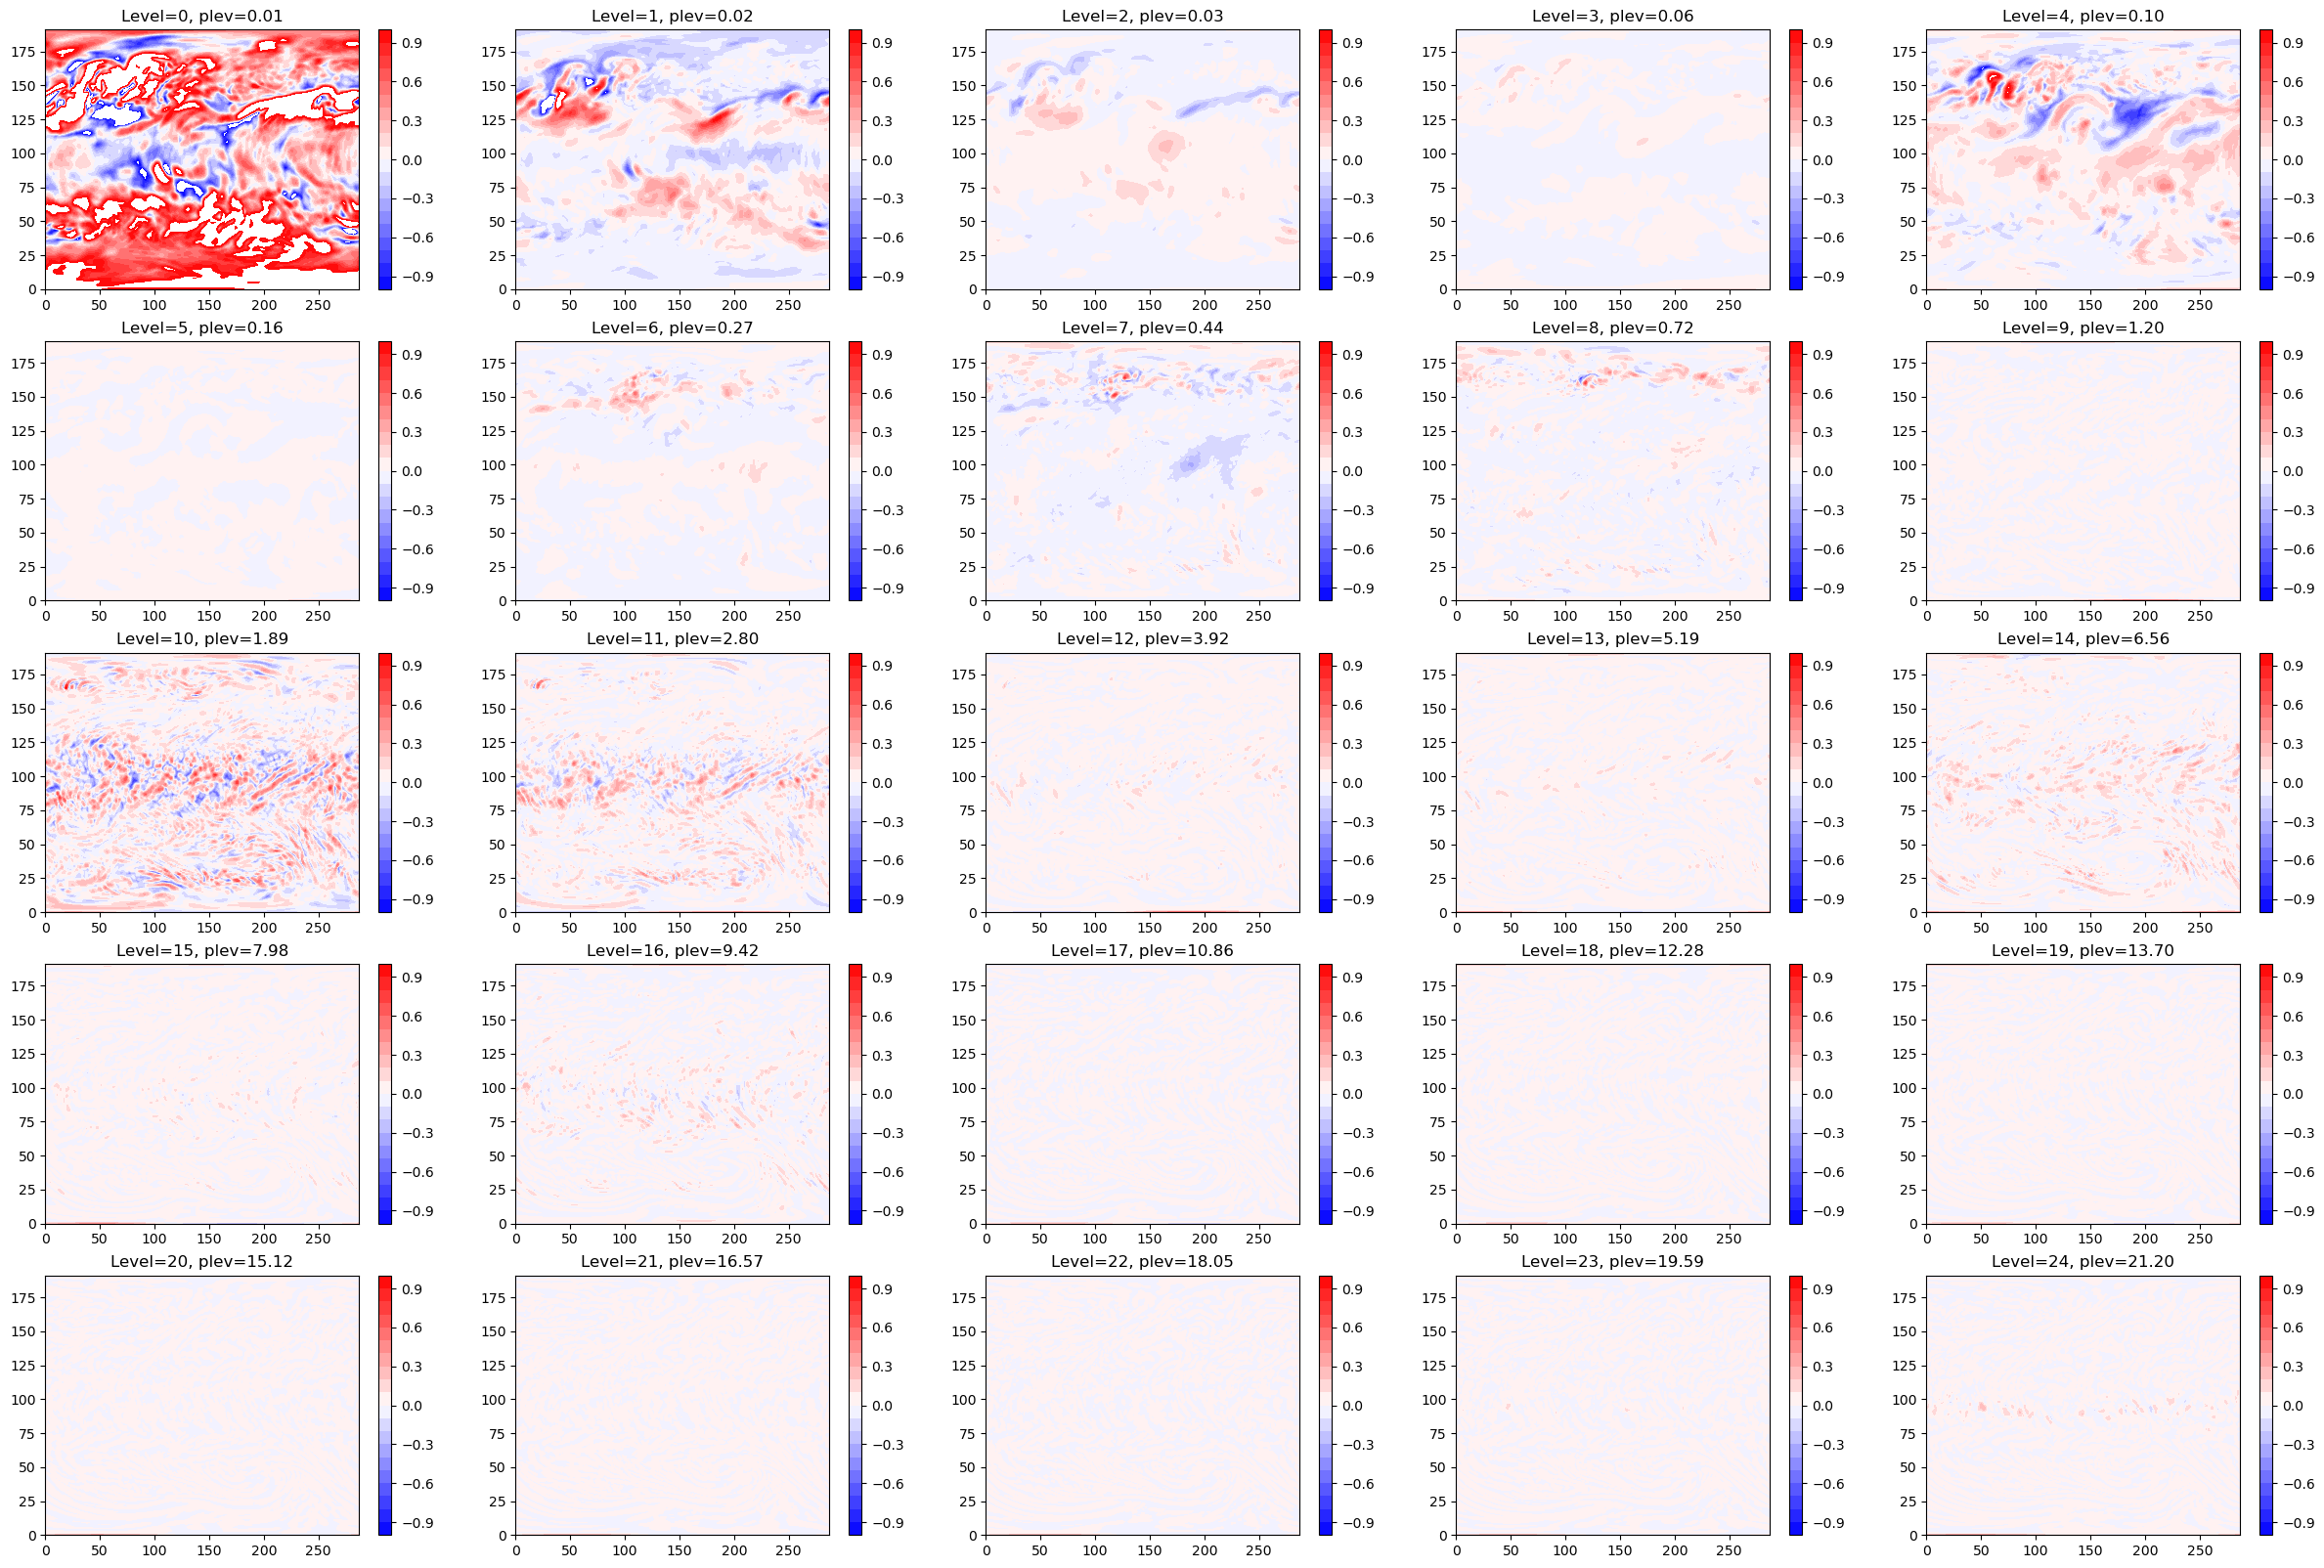

In [5]:
z=0
levs=1.0*np.linspace( -1,1,num=21) 

fig, ax = plt.subplots(5, 5, figsize=(30, 20))

# Flatten axs to easily access each subplot by index
ax = ax.flatten()

zees=[0,1,10,17,30,40,50,60,70,80]
zees=np.arange(25)
i=0
for z in zees:
    co = ax[i].contourf( te1[0,z,:,:] - te0[0,z,:,:] , cmap='bwr'  ,levels=levs )
    ax[i].set_title( f'Level={str( z )}, plev={X0.lev[z].values:0.2f}' )
    cb = plt.colorbar( co )
    i=i+1

In [6]:
nt,nz,ny,nx=np.shape( te0 )

diff=np.zeros( nz )

for z in np.arange( nz ):
    diff[z] = np.average(  np.average(  (te1[0,z,:,:] - te0[0,z,:,:] )**2 , axis=1) , axis=0 ) 

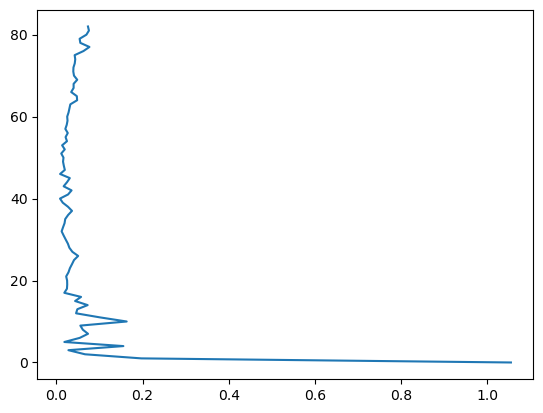

In [7]:
plt.plot( np.sqrt(diff)  , np.arange( nz) ) #X0.lev )

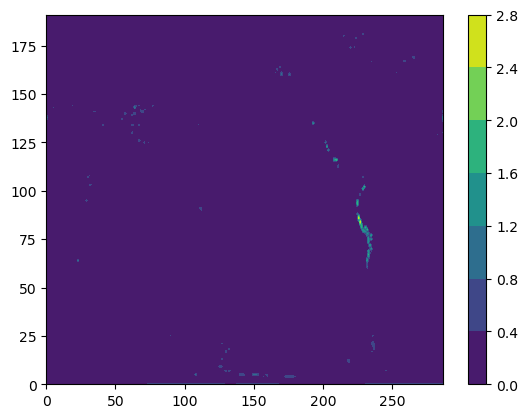

In [8]:

plt.contourf(  np.abs(X0.T.values[0,z,:,:]-X1.T.values[0,z,:,:]) )
plt.colorbar()# G

In [9]:
#########################################################
# Get gridded model-level ERA5 data
#########################################################


era5dir = "/glade/campaign/collections/rda/data/ds633.6/e5.oper.an.ml/"

year,month,day,hour0 = 1997,11,1,0

monStr=str( year ).zfill(4)+str(month).zfill(2)

hour1=hour0+5
ymdh0=str( year ).zfill(4)+str(month).zfill(2)+str(day).zfill(2)+str(hour0).zfill(2)
ymdh1=str( year ).zfill(4)+str(month).zfill(2)+str(day).zfill(2)+str(hour1).zfill(2)
ymdh=ymdh0+'_'+ymdh1


wrkdir=era5dir+monStr+"/"
#Define all file names for later use in dask function
#-----------------------------------------------------
spfile= wrkdir + 'e5.oper.an.ml.128_134_sp.regn320sc.'+ymdh+'.nc'
tfile = wrkdir + 'e5.oper.an.ml.0_5_0_0_0_t.regn320sc.'+ymdh+'.nc'
qfile = wrkdir + 'e5.oper.an.ml.0_5_0_1_0_q.regn320sc.'+ymdh+'.nc'
ufile = wrkdir + 'e5.oper.an.ml.0_5_0_2_2_u.regn320uv.'+ymdh+'.nc'
vfile = wrkdir + 'e5.oper.an.ml.0_5_0_2_3_v.regn320uv.'+ymdh+'.nc'
wfile = wrkdir + 'e5.oper.an.ml.0_5_0_2_8_w.regn320sc.'+ymdh+'.nc'

T_ERA   = xr.open_mfdataset( tfile , data_vars='different', coords='different')
PS_ERA   = xr.open_mfdataset( spfile , data_vars='different', coords='different')

#################################################
# Extract ERA5 temperature and surface pressure.
#################################################
te_era = T_ERA.T.values
ps_era = PS_ERA.SP.values


###############################
# Extract a's and b's for
# both ERA5 and CAM.
# Also, calculate 'eta' vertical
# coordinate
##############################
am_era, bm_era = T_ERA.a_model.values/100_000. , T_ERA.b_model.values

am_cam, bm_cam = X1.hyam.values , X1.hybm.values

eta_era = T_ERA.a_model.values/100_000. + T_ERA.b_model.values
eta_cam = X1.hyam.values + X1.hybm.values



In [10]:

workdir_ = '/glade/work/juliob'
if ( workdir_ not in sys.path ):
    sys.path.append(workdir_)
    print( f" a path to {workdir_} added in {__name__} ")


from PyRegridding.Drivers import RegridField as RgF
from PyRegridding.Utils import GridUtils as GrU 

############################
# Initialize dict for regridding
############################
RgObs={}
Src='ERA5'
Dst='fv1x1'

RegridObj = GrU.regrid_object_lib(RgOb=RgObs, src=Src, dst=Dst, RegridMethod='CONSERVE' )


 PyRegridding.Utils.MyConstants in /glade/work/juliob/PyRegridding/Utils 
Using Flexible parallel/serial VertRegrid 
 PyRegridding.Utils.MyConstants in /glade/work/juliob/PyRegridding/Utils 
ERA5_x_fv1x1_CONSERVE will be created !!!!
Got monikers ERA5 and fv1x1 from arguments

 
 Mapping ... ERA5 -x- fv1x1 
Ready to go ... ERA5 -x- fv1x1 0.0000 seconds
Finished Grid Mesh creation  0.3994 seconds
/glade/campaign/cesm/cesmdata/cseg/inputdata/share/scripgrids/fv0.9x1.25_141008.nc 
 (288, 192)
/glade/work/juliob/ERA5-proc/ERA5interp/grids/ERA5_640x1280_scrip.nc 
 (1280, 640)
Finished dstField,srcField  0.4019 seconds
/glade/work/juliob/GridFiles/Weights/ERA5_x_fv1x1_CONSERVE.nc
Reading weights from /glade/work/juliob/GridFiles/Weights/ERA5_x_fv1x1_CONSERVE.nc 
Finished generatind Regrd from wgts file 4.3125 seconds
 Not interpolating. Returning: regrd, srcf, dstf, ERA5, fv1x1 


In [11]:
#####################################################
# Horizontally regrid ERA5 temps to CAM horz grid
####################################################
te_era_x1 =RgF.Horz(xfld_Src=te_era , Src=Src, Dst=Dst , RegridObj_In= RegridObj )    # Horz=CAM, Vert=ERA5

Got monikers ERA5 and fv1x1 from arguments

 
 Mapping ... ERA5 -x- fv1x1 
 Getting (regrd, srcf, dstf) from argument 
Used GrU.latlon /glade/campaign/cesm/cesmdata/cseg/inputdata/share/scripgrids/fv0.9x1.25_141008.nc for lat lon 
 dstHkey=yx , ncol=0 , ny=192, nx=288 
 srcShape=tzyx, nzot=6, nz=137 


In [12]:
#############################################
# Using ERA5 surface pressure for both,
# calculate full 3D midlevel pressures 
# on ERA5 and CAM vertical model levels.
# Note, both of these are on the ERA5 
# horizontal grid
#############################################



nte,nze,nye,nxe = np.shape(te_era)
ntc,nzc,nyc,nxc = np.shape(te1)
pmid_era = np.zeros( (1, nze, nye, nxe) )      # Horz=ERA5, Vert=ERA5
pmid_era_Lcam = np.zeros( (1, nzc, nye, nxe) ) # Horz=ERA5, Vert=CAM

for t in np.arange(1):
    for y in np.arange(nye):
        for x in np.arange(nxe):
            pmid_era_z = am_era*100_000. + bm_era*ps_era[t,y,x]
            pmid_era[t,:,y,x] = pmid_era_z
            pmid_era_Lcam_z = am_cam*100_000. + bm_cam*ps_era[t,y,x]
            pmid_era_Lcam[t,:,y,x] = pmid_era_Lcam_z




In [13]:
from scipy import interpolate as intr


In [14]:
################################################
# Interpolate te_era_x1 (Horz=CAM, Vert=ERA5) '
# to CAM vertical grid in eta coordinates
#################################################

nt,nz,ny,nx = np.shape(te1)

te_era_x1_Lcam_eta = np.zeros( (nt,nz,ny,nx) )

for t in np.arange(nt):
    for y in np.arange( ny ):
        for x in np.arange( nx ):
        
            fint=intr.interp1d( x = eta_era, y=te_era_x1[t,:,y,x] , 
                                fill_value='extrapolate', kind='quadratic'  )
            te_era_x1_Lcam_eta[t,:,y,x] = fint(   eta_cam  )


In [15]:
################################################
# Interpolate te_era (Horz=ERA5, Vert=ERA5) '
# to CAM vertical grid in eta coordinates,
#
# THEN regrid onto CAM horz grid
#################################################



nte,nze,nye,nxe = np.shape(te_era)

te_era_Lcam_eta = np.zeros( (1,  nz  ,nye,nxe) )

for t in np.arange(1):
    for y in np.arange( nye ):
        for x in np.arange( nxe ):
        
            fint=intr.interp1d( x = eta_era, y=te_era[t,:,y,x] , 
                                fill_value='extrapolate', kind='quadratic'  )
            te_era_Lcam_eta[t,:,y,x] = fint(   eta_cam  )
    print( f"Did t={t}" )
    
te_era_Lcam_eta_x1 =RgF.Horz(xfld_Src=te_era_Lcam_eta , Src=Src, Dst=Dst , RegridObj_In= RegridObj )

Did t=0
Got monikers ERA5 and fv1x1 from arguments

 
 Mapping ... ERA5 -x- fv1x1 
 Getting (regrd, srcf, dstf) from argument 
Used GrU.latlon /glade/campaign/cesm/cesmdata/cseg/inputdata/share/scripgrids/fv0.9x1.25_141008.nc for lat lon 
 dstHkey=yx , ncol=0 , ny=192, nx=288 
 srcShape=tzyx, nzot=1, nz=83 


In [16]:
################################################
# Interpolate te_era (Horz=ERA5, Vert=ERA5) 
# vertically, using ERA5 and CAM 3D pressure fields,
#
# THEN regrid onto CAM horz grid
#################################################

nte,nze,nye,nxe = np.shape(te_era)

te_era_Lcam_prs = np.zeros( (1,  nz  ,nye,nxe) )

for t in np.arange(1):
    for y in np.arange( nye ):
        for x in np.arange( nxe ):
            z_era = pmid_era[t,:,y,x] # Local ERA5 pressure profile
            fint=intr.interp1d( x = z_era, y=te_era[t,:,y,x] , 
                                fill_value='extrapolate', kind='quadratic'  )
            z_cam = pmid_era_Lcam[t,:,y,x] # Local CAM pressure profile
            te_era_Lcam_prs[t,:,y,x] = fint(   z_cam  )
    print( f"Did t={t}" )

te_era_Lcam_prs_f09 =RgF.Horz(xfld_Src=te_era_Lcam_prs , Src=Src, Dst=Dst , RegridObj_In= RegridObj )


Did t=0
Got monikers ERA5 and fv1x1 from arguments

 
 Mapping ... ERA5 -x- fv1x1 
 Getting (regrd, srcf, dstf) from argument 
Used GrU.latlon /glade/campaign/cesm/cesmdata/cseg/inputdata/share/scripgrids/fv0.9x1.25_141008.nc for lat lon 
 dstHkey=yx , ncol=0 , ny=192, nx=288 
 srcShape=tzyx, nzot=1, nz=83 


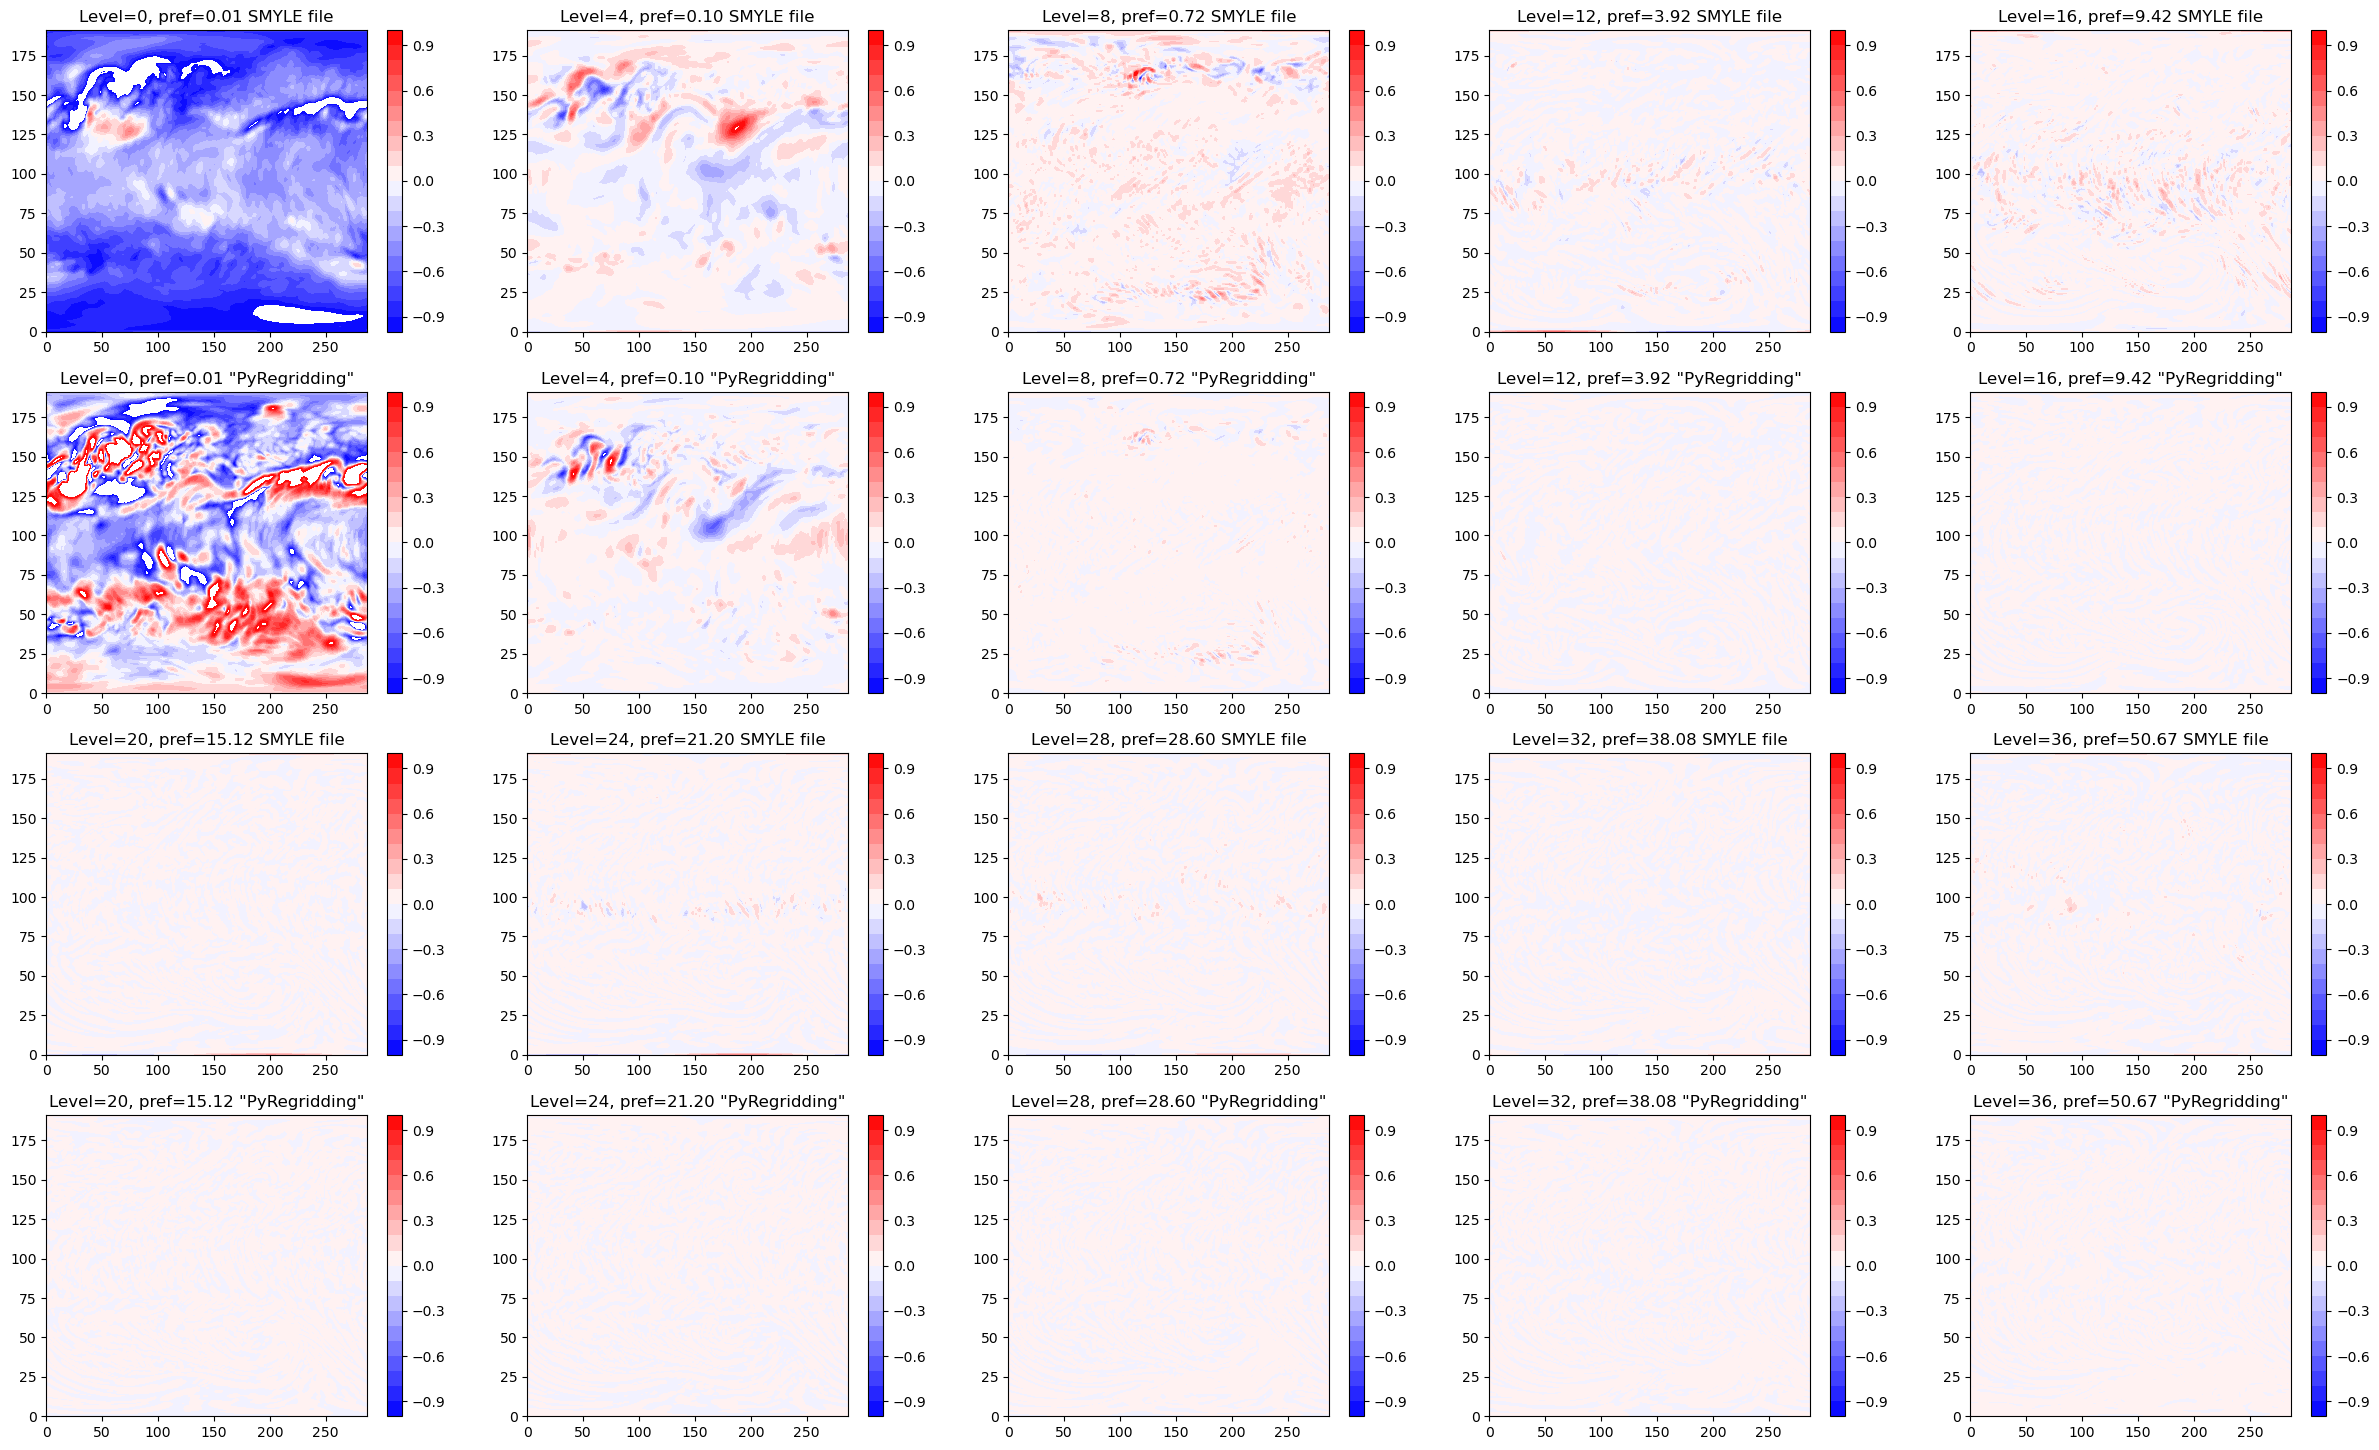

In [17]:
################################################################################
# Make differences of te_era_Lcam_prs_x1 (te_era ==> Lcam_prs ==> CAM horz) 
# versus: 
#        te0, SMYLE file generated using Jerry Olson's script
#        te1, file generated using my Python code "PyRegridding"
###############################################################################

levs=np.linspace( -1,1,num=21) 

fig, ax = plt.subplots(4, 5, figsize=(30, 18))

# Flatten axs to easily access each subplot by index
ax = ax.flatten()

zees=[0,1,10,20,30,40,50,60,70,80]
zees=np.arange(0,40,step=4)
#zees=np.arange(0,80,step=8)

i=0
for z in zees:
    co = ax[i].contourf( te0[0,z,:,:] -te_era_Lcam_prs_f09[0,z,:,:]  , cmap='bwr'  ,levels=levs )
    cu = ax[i+5].contourf( te1[0,z,:,:] -te_era_Lcam_prs_f09[0,z,:,:] , cmap='bwr'  ,levels=levs )
    ax[i].set_title( f'Level={str( z )}, pref={X0.lev[z].values:0.2f} SMYLE file' )
    ax[i+5].set_title( f'Level={str( z )}, pref={X0.lev[z].values:0.2f} "PyRegridding"' )
    cb = plt.colorbar( co )
    cb2 = plt.colorbar( cu )
    if i==4:
        i=i+5+1
    else:
        i=i+1

In [19]:
print( np.shape(pmid_era))
print( np.shape(pmid_era_Lcam))


(1, 137, 640, 1280)
(1, 83, 640, 1280)
